In [1]:
# Customer Orders Analysis (Pandas + SQL)

"""
Project: Customer Orders Analysis (Pandas + SQL)

This project generates a synthetic e-commerce dataset (customers, addresses, orders, shipping, payments)
and demonstrates typical analytics tasks using both SQL (SQLite) and Pandas:

1) Data model & relationships (keys + cardinalities)
2) Revenue over time (monthly revenue for completed & paid orders)
3) Order status funnel (counts + share; optional visualization)

Optional additions:
- Top customers by revenue
- Category performance
- Payment methods distribution
- Average delivery time
- Return rate
"""

# =========================
# Imports & Configuration
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import sqlite3

# Reproducibility
np.random.seed(42)
random.seed(42)

print(" Libraries imported successfully!")


 Libraries imported successfully!


In [2]:
# =========================
# 1) Data Generation
# =========================

def generate_customers(n_customers: int = 150) -> pd.DataFrame:
    vornamen = [
        'Max','Anna','Thomas','Julia','Michael','Sarah','Christian','Lisa',
        'Andreas','Nicole','Stefan','Jessica','Daniel','Melanie','Martin',
        'Katharina','Sebastian','Nina','Patrick','Stephanie','Markus','Laura',
        'Alexander','Jennifer','Jan','Vanessa','Florian','Sabrina','Tobias',
        'Michelle','Benjamin','Nadine','David','Julia','Philipp','Christina'
    ]
    nachnamen = [
        'Müller','Schmidt','Schneider','Fischer','Weber','Meyer','Wagner',
        'Becker','Schulz','Hoffmann','Schäfer','Koch','Bauer','Richter',
        'Klein','Wolf','Schröder','Neumann','Schwarz','Zimmermann','Braun',
        'Krüger','Hofmann','Hartmann','Lange','Schmitt','Werner','Schmitz',
        'Krause','Meier','Lehmann','Schmid','Schulze','Maier','Köhler'
    ]

    kunden_ids = list(range(1, n_customers + 1))
    return pd.DataFrame({
        "KundenID": kunden_ids,
        "Vorname": [random.choice(vornamen) for _ in kunden_ids],
        "Nachname": [random.choice(nachnamen) for _ in kunden_ids],
        "E_Mail": [f"kunde_{i}@email.de" for i in kunden_ids],
        "Telefon": [f"+49 {random.randint(100,999)} {random.randint(1000000,9999999)}" for _ in kunden_ids],
        "Registrierungsdatum": pd.date_range(start="2023-01-01", periods=n_customers, freq="2D"),
    })


def generate_addresses(kunden_ids: list[int]) -> pd.DataFrame:
    städte = [
        'Berlin','München','Hamburg','Köln','Frankfurt','Stuttgart','Düsseldorf',
        'Dortmund','Essen','Leipzig','Bremen','Dresden','Hannover','Nürnberg',
        'Duisburg','Bochum','Wuppertal','Bielefeld','Bonn','Münster'
    ]

    postleitzahlen_städte = {
        'Berlin': list(range(10115,10179)),
        'München': list(range(80331,80339)),
        'Hamburg': list(range(20095,20099)),
        'Köln': list(range(50667,50679)),
        'Frankfurt': list(range(60306,60329)),
        'Stuttgart': list(range(70173,70191)),
        'Düsseldorf': list(range(40210,40239)),
        'Dortmund': list(range(44135,44149)),
        'Essen': list(range(45127,45149)),
        'Leipzig': list(range(4103,4357)),
    }

    streets = ['Hauptstraße','Bahnhofstraße','Kirchstraße','Gartenstraße','Parkstraße',
               'Schulstraße','Dorfstraße','Waldstraße','Mühlenstraße','Bergstraße']

    bundesländer = ['Berlin','Bayern','Hamburg','Nordrhein-Westfalen','Baden-Württemberg',
                    'Hessen','Sachsen','Niedersachsen','Bremen','Thüringen']

    rows = []
    for i, kid in enumerate(kunden_ids, start=1):
        city = random.choice(städte)
        plz_pool = postleitzahlen_städte.get(city, [random.randint(10000, 99999)])
        rows.append({
            "AdressID": i,
            "KundenID": kid,
            "Straße": f"{random.choice(streets)} {random.randint(1,150)}",
            "Postleitzahl": random.choice(plz_pool),
            "Stadt": city,
            "Bundesland": random.choice(bundesländer)
        })
    return pd.DataFrame(rows)


def generate_orders(kunden_ids: list[int], n_orders: int = 180) -> pd.DataFrame:
    produktkategorien = ['Elektronik','Möbel','Kleidung','Bücher','Sport','Haushalt','Spielzeug','Lebensmittel','Garten','Kosmetik']
    produkte = {
        'Elektronik': ['Laptop','Smartphone','Tablet','Kopfhörer','Monitor'],
        'Möbel': ['Sofa','Tisch','Stuhl','Schrank','Bett'],
        'Kleidung': ['Hemd','Hose','Jacke','Schuhe','Pullover'],
        'Bücher': ['Roman','Fachbuch','Kinderbuch','Kochbuch','Reiseführer'],
        'Sport': ['Laufschuhe','Yogamatte','Hanteln','Fahrrad','Tennisracket'],
        'Haushalt': ['Staubsauger','Kaffeemaschine','Toaster','Mixer','Bügeleisen'],
        'Spielzeug': ['Puzzle','Bauklötze','Puppe','Spielzeugauto','Brettspiel'],
        'Lebensmittel': ['Bio-Gemüsebox','Kaffee','Tee','Honig','Öl'],
        'Garten': ['Gartenschere','Schaufel','Blumentopf','Samen','Gießkanne'],
        'Kosmetik': ['Creme','Shampoo','Parfüm','Make-up','Sonnencreme']
    }

    preis_mapping = {
        'Elektronik': (50, 1500),
        'Möbel': (100, 800),
        'Kleidung': (20, 150),
        'Bücher': (10, 50),
        'Sport': (30, 300),
        'Haushalt': (25, 400),
        'Spielzeug': (15, 100),
        'Lebensmittel': (10, 80),
        'Garten': (20, 150),
        'Kosmetik': (15, 120)
    }

    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 12, 31)

    rows = []
    for oid in range(1, n_orders + 1):
        kid = random.choice(kunden_ids)
        cat = random.choice(produktkategorien)
        prod = random.choice(produkte[cat])

        bestelldatum = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

        # simple time-based status heuristic
        age_days = (datetime.now() - bestelldatum).days
        if age_days > 30:
            status = random.choice(['Abgeschlossen','Storniert','Versandt','Retourniert'])
        elif age_days > 7:
            status = random.choice(['In Bearbeitung','Versandt','Ausstehend'])
        else:
            status = random.choice(['In Bearbeitung','Ausstehend'])

        preis_min, preis_max = preis_mapping[cat]
        einzelpreis = round(random.uniform(preis_min, preis_max), 2)
        menge = random.randint(1, 5)

        rows.append({
            "BestellID": oid,
            "KundenID": kid,
            "Produkt": prod,
            "Kategorie": cat,
            "Menge": menge,
            "Einzelpreis": einzelpreis,
            "Gesamtpreis": round(einzelpreis * menge, 2),
            "Bestelldatum": bestelldatum,
            "Status": status
        })

    return pd.DataFrame(rows)


def generate_shipping(orders: pd.DataFrame) -> pd.DataFrame:
    shipped = orders[orders["Status"].isin(["Versandt","Abgeschlossen","Retourniert"])].copy()

    rows = []
    for sid, (_, o) in enumerate(shipped.iterrows(), start=1):
        versanddatum = o["Bestelldatum"] + timedelta(days=random.randint(1,5))
        carrier = random.choice(["DHL","DPD","Hermes","UPS","GLS"])
        tracking = f"{carrier}{random.randint(1000000000,9999999999)}DE"

        lieferdatum = None
        if o["Status"] in ["Abgeschlossen","Retourniert"]:
            lieferdatum = versanddatum + timedelta(days=random.randint(1,3))

        rows.append({
            "VersandID": sid,
            "BestellID": int(o["BestellID"]),
            "Versanddatum": versanddatum,
            "Lieferdatum": lieferdatum,
            "Versandunternehmen": carrier,
            "TrackingNummer": tracking,
            "Versandkosten": round(random.uniform(3.99, 12.99), 2)
        })

    return pd.DataFrame(rows)


def generate_payments(orders: pd.DataFrame) -> pd.DataFrame:
    methods = ['Kreditkarte','Lastschrift','PayPal','Überweisung','Klarna','Rechnung']

    rows = []
    for pid, (_, o) in enumerate(orders.iterrows(), start=1):
        method = random.choice(methods)

        if o["Status"] == "Storniert":
            status = "Nicht bezahlt"
            date = None
            paid = 0.0
        else:
            status = random.choice(["Bezahlt","Ausstehend","Teilweise bezahlt"])
            if status == "Bezahlt":
                date = o["Bestelldatum"] + timedelta(days=random.randint(0,3))
                paid = float(o["Gesamtpreis"])
            elif status == "Teilweise bezahlt":
                date = o["Bestelldatum"] + timedelta(days=random.randint(0,5))
                paid = round(float(o["Gesamtpreis"]) * random.uniform(0.3, 0.7), 2)
            else:
                date = None
                paid = 0.0

        rows.append({
            "ZahlungID": pid,
            "BestellID": int(o["BestellID"]),
            "Zahlungsmethode": method,
            "Betrag": float(o["Gesamtpreis"]),
            "GezahlterBetrag": float(paid),
            "Zahlungsstatus": status,
            "Zahlungsdatum": date
        })

    return pd.DataFrame(rows)


In [3]:
# =========================
# 2) Build Dataset + SQLite
# =========================

kunden = generate_customers(150)
adressen = generate_addresses(kunden["KundenID"].tolist())
bestellungen_df = generate_orders(kunden["KundenID"].tolist(), 180)
versand_df = generate_shipping(bestellungen_df)
zahlungen_df = generate_payments(bestellungen_df)

print("Tables created:")
print("Kunden:", kunden.shape)
print("Adressen:", adressen.shape)
print("Bestellungen:", bestellungen_df.shape)
print("Versand:", versand_df.shape)
print("Zahlungen:", zahlungen_df.shape)

# SQLite (in-memory)
conn = sqlite3.connect(":memory:")
kunden.to_sql("Kunden", conn, index=False, if_exists="replace")
adressen.to_sql("Adressen", conn, index=False, if_exists="replace")
bestellungen_df.to_sql("Bestellungen", conn, index=False, if_exists="replace")
versand_df.to_sql("Versand", conn, index=False, if_exists="replace")
zahlungen_df.to_sql("Zahlungen", conn, index=False, if_exists="replace")

print(" SQLite database ready: Kunden, Adressen, Bestellungen, Versand, Zahlungen")


Tables created:
Kunden: (150, 6)
Adressen: (150, 6)
Bestellungen: (180, 9)
Versand: (130, 7)
Zahlungen: (180, 7)
 SQLite database ready: Kunden, Adressen, Bestellungen, Versand, Zahlungen


In [4]:
# =========================
# Task 1) Data Relationships
# =========================

"""
Keys & Relationships (expected model)

Kunden (KundenID) 1 ─── 1 Adressen (KundenID)
Kunden (KundenID) 1 ─── N Bestellungen (KundenID)
Bestellungen (BestellID) 1 ─── 0..1 Versand (BestellID)   [only if shipped/closed/returned]
Bestellungen (BestellID) 1 ─── 1 Zahlungen (BestellID)

Notes:
- In this synthetic dataset, each customer has exactly one address.
- Each order has exactly one payment entry.
- Shipping exists only for certain order statuses.
"""

# quick checks
print("Orders per customer (summary):")
display(bestellungen_df["KundenID"].value_counts().describe())

print("\nShipping per order (summary):")
display(versand_df["BestellID"].value_counts().describe())

print("\nPayments per order (summary):")
display(zahlungen_df["BestellID"].value_counts().describe())


Orders per customer (summary):


count    97.000000
mean      1.855670
std       1.127217
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       7.000000
Name: count, dtype: float64


Shipping per order (summary):


count    130.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: count, dtype: float64


Payments per order (summary):


count    180.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: count, dtype: float64

,Monat,Umsatz
0,2024-01,179.20
1,2024-02,442.06
2,2024-04,5320.72
3,2024-07,659.56
4,2024-08,199.86
5,2024-09,2711.85
6,2024-11,73.41
7,2024-12,273.37


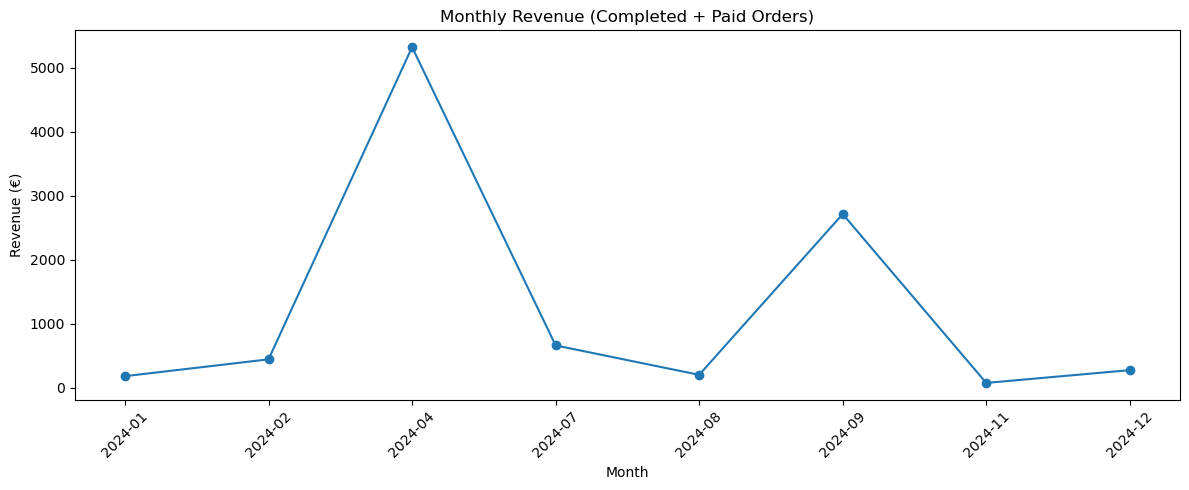

In [5]:
# =========================
# Task 2) Revenue Over Time
# =========================

"""
Monthly revenue for orders that are:
- Status = 'Abgeschlossen'
- Zahlungsstatus = 'Bezahlt'
Grouped by month
"""

umsatz_data = pd.read_sql_query("""
    SELECT 
        strftime('%Y-%m', b.Bestelldatum) AS Monat,
        SUM(b.Gesamtpreis) AS Umsatz
    FROM Bestellungen b
    JOIN Zahlungen z ON b.BestellID = z.BestellID
    WHERE b.Status = 'Abgeschlossen'
      AND z.Zahlungsstatus = 'Bezahlt'
    GROUP BY strftime('%Y-%m', b.Bestelldatum)
    ORDER BY Monat
""", conn)

display(umsatz_data)

plt.figure(figsize=(12, 5))
plt.plot(umsatz_data["Monat"], umsatz_data["Umsatz"], marker="o")
plt.title("Monthly Revenue (Completed + Paid Orders)")
plt.xlabel("Month")
plt.ylabel("Revenue (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,Status,Anzahl,Prozent
0,Versandt,39,21.67
1,Abgeschlossen,41,22.78
2,Storniert,50,27.78
3,Retourniert,50,27.78


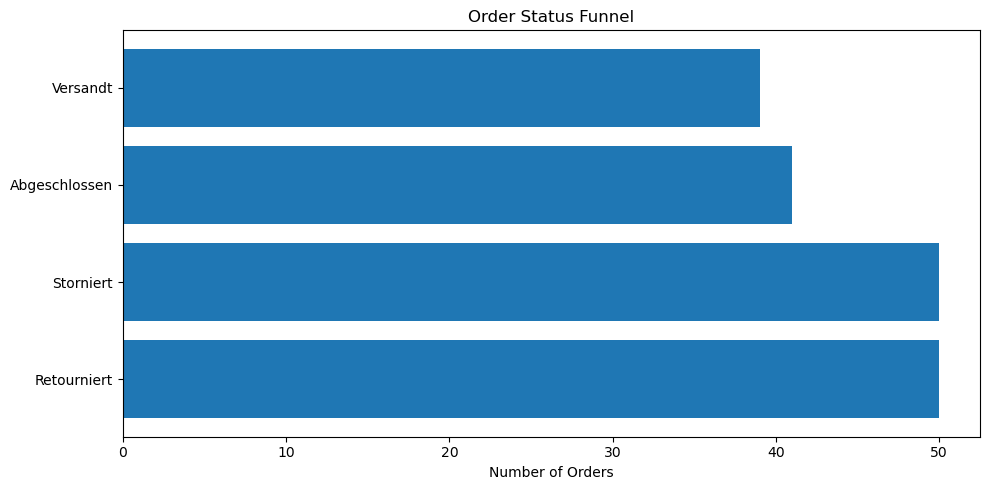

In [6]:
# =========================
# Task 3) Order Status Funnel
# =========================

funnel_data = pd.read_sql_query("""
    SELECT 
        Status,
        COUNT(*) AS Anzahl,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM Bestellungen), 2) AS Prozent
    FROM Bestellungen
    GROUP BY Status
""", conn)

status_order = ["Ausstehend","In Bearbeitung","Versandt","Abgeschlossen","Storniert","Retourniert"]

funnel_data["Status"] = pd.Categorical(funnel_data["Status"], categories=status_order, ordered=True)
funnel_data = funnel_data.sort_values("Status").reset_index(drop=True)

display(funnel_data)

plt.figure(figsize=(10, 5))
plt.barh(funnel_data["Status"], funnel_data["Anzahl"])
plt.title("Order Status Funnel")
plt.xlabel("Number of Orders")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [7]:
# =========================
# Optional Analyses
# =========================

# Top customers by revenue (completed + paid)
top_kunden = pd.read_sql_query("""
    SELECT 
        k.KundenID,
        k.Vorname || ' ' || k.Nachname AS Kunde,
        SUM(b.Gesamtpreis) AS Gesamtumsatz
    FROM Bestellungen b
    JOIN Zahlungen z ON b.BestellID = z.BestellID
    JOIN Kunden k ON b.KundenID = k.KundenID
    WHERE b.Status = 'Abgeschlossen' AND z.Zahlungsstatus = 'Bezahlt'
    GROUP BY k.KundenID
    ORDER BY Gesamtumsatz DESC
    LIMIT 10
""", conn)
display(top_kunden)

# Category analysis
produktanalyse = pd.read_sql_query("""
    SELECT 
        Kategorie,
        COUNT(*) AS Anzahl_Bestellungen,
        SUM(Gesamtpreis) AS Umsatz
    FROM Bestellungen
    GROUP BY Kategorie
    ORDER BY Anzahl_Bestellungen DESC
""", conn)
display(produktanalyse)

# Payment methods
zahlungsmethoden = pd.read_sql_query("""
    SELECT 
        Zahlungsmethode,
        COUNT(*) AS Anzahl,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM Zahlungen), 2) AS Prozent
    FROM Zahlungen
    GROUP BY Zahlungsmethode
    ORDER BY Anzahl DESC
""", conn)
display(zahlungsmethoden)

# Avg delivery time (days)
lieferzeit = pd.read_sql_query("""
    SELECT 
        ROUND(AVG(julianday(Lieferdatum) - julianday(Versanddatum)), 2) AS Durchschnittliche_Lieferzeit_Tage
    FROM Versand
    WHERE Lieferdatum IS NOT NULL
""", conn)
display(lieferzeit)

# Return rate
retourenrate = pd.read_sql_query("""
    SELECT 
        ROUND(SUM(CASE WHEN Status = 'Retourniert' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS Retourenrate_Prozent
    FROM Bestellungen
""", conn)
display(retourenrate)


,KundenID,Kunde,Gesamtumsatz
0,78,Martin Köhler,4531.88
1,118,Lisa Wolf,2711.85
2,45,Sarah Lehmann,788.84
3,65,Nina Bauer,659.56
4,140,Julia Wagner,355.62
5,100,Martin Schwarz,246.24
6,62,Jennifer Wagner,199.86
7,98,Vanessa Hoffmann,179.20
8,116,Christina Weber,86.44
9,36,Christian Krüger,73.41


,Kategorie,Anzahl_Bestellungen,Umsatz
0,Haushalt,25,16321.44
1,Spielzeug,21,3612.75
2,Lebensmittel,21,3096.12
3,Kleidung,21,6507.81
4,Garten,21,5859.21
5,Sport,17,10810.77
6,Möbel,15,20698.50
7,Bücher,15,913.76
8,Elektronik,13,46633.71
9,Kosmetik,11,1986.14


,Zahlungsmethode,Anzahl,Prozent
0,Lastschrift,32,17.78
1,Rechnung,31,17.22
2,PayPal,31,17.22
3,Überweisung,30,16.67
4,Klarna,29,16.11
5,Kreditkarte,27,15.00


,Durchschnittliche_Lieferzeit_Tage
0,2.08


,Retourenrate_Prozent
0,27.78


In [8]:
# =========================
# Project Notes / Learnings
# =========================

"""
What I practiced in this project:
- Modeling a small relational dataset (customers, orders, payments, shipping)
- SQL joins + filtering for business KPIs (completed & paid revenue)
- Monthly aggregation with SQLite (strftime)
- Funnel reporting (counts + percentages + logical ordering)
- Quick exploratory extensions (top customers, category performance, delivery time, return rate)

Tooling note:
- I used SQL for aggregation because it is compact and efficient for grouping/filtering.
- Visualization is done with matplotlib to keep dependencies minimal and portable.
"""
print("Project notebook completed.")


Project notebook completed.
